# Fuga WakeModel

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.examples.data.hornsrev1 import V80, Hornsrev1Site, wt9_x, wt9_y
from py_wake.wake_models.fuga import Fuga
from py_wake.tests.test_files.fuga import LUT_path_2MW_z0_0_03
site = Hornsrev1Site()
windTurbines = V80()
wake_model = Fuga(LUT_path_2MW_z0_0_03, site, windTurbines)

The `Fuga` is a subclass of the general `WakeModel` class, see documentation [here](https://topfarm.pages.windenergy.dtu.dk/PyWake/wake_models/WakeModel.html)

It uses the wake calculated by [Fuga](http://www.wasp.dk/fuga)

The implementation of `WakeModel` is highly vectorized and therefore suffixes are used to indicate the dimension of variables. The suffixes used in this context are:

- i: turbines ordered by id
- k: wind speeds
- l: wind directions

This means that `WS_ilk[0,1,2]` holds the wind speed at the first turbine for the second wind direction and third wind speed


`WakeModel` contains a method, [`calc_wake`](https://topfarm.pages.windenergy.dtu.dk/PyWake/wake_models/WakeModel.html#py_wake.wake_model.WakeModel.calc_wake), to calculate the effective wind speed, turbulence intensity (not implemented yet), power and thrust coefficient.

Let us try to calculate the effective wind speed for two V80 turbines separated by 200m in 10m/s and wind direction parallel to a line between the two turbines

In [5]:
WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk,*_ = wake_model.calc_wake(
    x_i=[0,0],
    y_i=[200,0],
    ws=10,
    wd=0)

for i in [0,1]:
    print ('Turbine', i)
    print ('Effective wind speed %fm/s'%WS_eff_ilk[i,0,0])
    print ('Power production %.2fW'%power_ilk[i,0,0])
    print ('Thrust coefficient %f'%ct_ilk[i,0,0])
    print()


Turbine 0
Effective wind speed 10.000000m/s
Power production 1341000.00W
Thrust coefficient 0.793000

Turbine 1
Effective wind speed 7.388158m/s
Power production 551605.26W
Thrust coefficient 0.805388



To calculate this, `calc_wake`, uses two wake-model specific methods, `calc_deficit` and `calc_effective_WS`.

`calc_deficit` calculates the deficit:

In [6]:
deficit = wake_model.calc_deficit(
    WS_lk=np.array([[10]]), # wind speed at current turbine
    WS_eff_lk=np.array([[10]]), # effective wind speed at current turbine
    dw_jl=np.array([[200]]), # down wind distance
    hcw_jl=np.array([[0]]), # cross wind distance (both horizontal and vertical)
    dh_jl=np.array([[0]]), # hub height difference
    h_l=np.array([[70]]), # hub height of current turbine
    ct_lk=np.array([[0.793000]])) # thrust coefficient

print (deficit[0,0,0])


2.6118421076046077


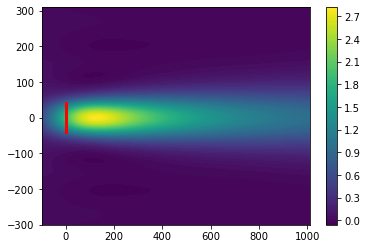

In [7]:
x = np.arange(-300,310,1.)
y = np.arange(-100,1010,1.)
X,Y = np.meshgrid(x,y)
Z = np.zeros_like(X)
deficit_map = wake_model.calc_deficit(
    WS_lk=np.array([[10]]), # wind speed at current turbine
    WS_eff_lk=np.array([[10]]), # effective wind speed at current turbine
    dw_jl=Y, # down wind distance
    hcw_jl=np.abs(X), # cross wind distance (both horizontal and vertical)
    dh_jl=Z, # hub height difference
    h_l=np.array([[70]]), # hub height of current turbine
    ct_lk=np.array([[0.793000]])) # thrust coefficient

c = plt.contourf(Y,X,deficit_map[:,:,0],100)
plt.colorbar(c)
plt.plot([0,0],[-40,40],'r',lw=3)

while `calc_effective_WS` calculates the effective wind speed by subtracting the deficits from all upstream turbines from the local wind speed. For `Fuga` it subtracts the sum of deficits

In [10]:
wake_model.calc_effective_WS(
    WS_lk=np.array([[10]]), 
    deficit_ilk=deficit)

array([[7.38815789]])

Finally, `WakeModel`, contains the method `wake_map` to find the effective wind speed at arbitrary positions

In [12]:
#calculate the wake 200m down stream of a V80
X_j, Y_j, WS_eff_jlk, WS_jlk, P_ilk = wake_model.ws_map(x_j=[200], y_j=[0], h=70, 
                                                        wt_x_i=[0], wt_y_i=[0], wt_type_i=[0], wt_h_i=[70], 
                                                        wd=270, ws=10)
print (WS_eff_jlk)

[[[7.38815789]]]


For standard purposes, however, we do not call these methods manually. Instead we use the functions in `AEPCalculator`

**Calculate AEP**

AEP pr turbine: [9.04903881 9.20058899]


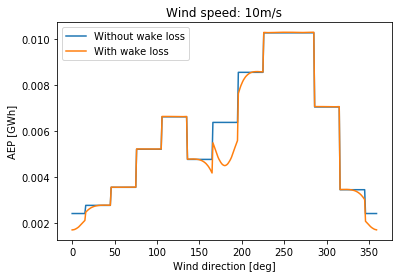

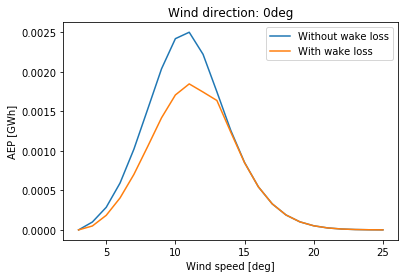

In [13]:
from py_wake.aep_calculator import AEPCalculator

site = Hornsrev1Site()
aep_calc = AEPCalculator(wake_model)

aep_gwh_ilk = aep_calc.calculate_AEP(x_i=[0,0], y_i=[0,-200])
aep_gwh_noloss_ilk = aep_calc.calculate_AEP_no_wake_loss(x_i=[0,0], y_i=[0,-200])


# AEP pr turbine
print ('AEP pr turbine:', aep_gwh_ilk.sum((1,2)))

# AEP pr wind direction
plt.plot(aep_gwh_noloss_ilk[:,:,7].sum(0), label='Without wake loss')
plt.plot(aep_gwh_ilk[:,:,7].sum(0), label='With wake loss')
plt.title('Wind speed: 10m/s')
plt.xlabel('Wind direction [deg]')
plt.ylabel('AEP [GWh]')
plt.legend()

# AEP pr wind speed
plt.figure()
plt.plot(site.default_ws, aep_gwh_noloss_ilk[:,0].sum(0), label='Without wake loss')
plt.plot(site.default_ws, aep_gwh_ilk[:,0].sum(0), label='With wake loss')
plt.title('Wind direction: 0deg')
plt.xlabel('Wind speed [deg]')
plt.ylabel('AEP [GWh]')
plt.legend()

**Wake map**

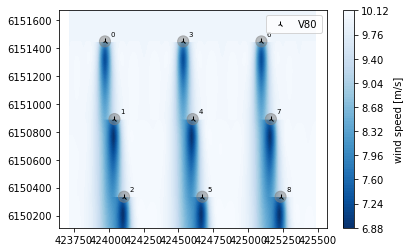

In [14]:
import matplotlib.pyplot as plt
x,y = wt9_x, wt9_y
aep_calc.plot_wake_map(wt_x=x, wt_y=y, wd=[0], ws=[10])
windTurbines.plot(x, y)
plt.show()


**Effective wind speed, power and thrust coefficient**

In [15]:
# wind from 0 deg(index=0) and 10m/s (index=7)

aep_calc.calculate_AEP(x_i=[0,0], y_i=[0,-200])
print ("Effective wind speed: wt0: %f\twt1: %f"%tuple(aep_calc.WS_eff_ilk[:,0,7])) 
print ("Power: wt0: %dW\twt1: %dW"%tuple(aep_calc.power_ilk[:,0,7])) 
print ("Thrust coefficient: wt0: %f\twt1: %f"%tuple(aep_calc.ct_ilk[:,0,7])) 
print ("Probability of ws=10m/s and wd=0deg: %f"%aep_calc.P_ilk[0,0,7])

Effective wind speed: wt0: 10.000000	wt1: 7.388158
Power: wt0: 1341000W	wt1: 551605W
Thrust coefficient: wt0: 0.793000	wt1: 0.805388
Probability of ws=10m/s and wd=0deg: 0.000103
